In [2]:
from torchvision.models import vgg16
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from torchsummary import summary
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F
import copy


%matplotlib inline

# G-Drive

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# DATA_PATH = r"/content/drive/My Drive/MLLAB_Project_3/data"
# N_SAMPLES = 100

# Load data and extract features with VGG

## Load data

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

False


In [5]:
torch.manual_seed(7)
DATA_PATH = r"./data"
N_SAMPLES = 10

dataset = datasets.ImageFolder(DATA_PATH, transform=transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1000, shuffle=True)

images, labels = next(iter(dataloader))
labels = 1 - labels # disease = 1, healthy = 0
print(images.shape)
print(labels.shape)

torch.Size([1000, 3, 256, 256])
torch.Size([1000])


Plot an image

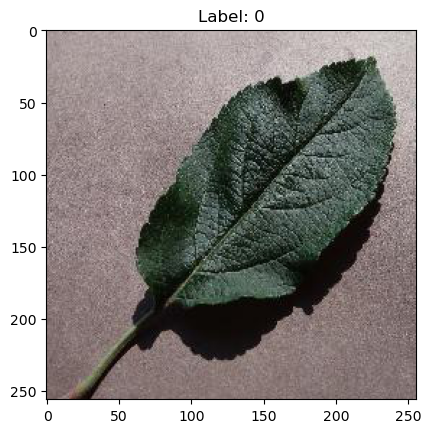

In [6]:
image = images[0]
plt.title("Label: {}".format(labels[0]))
plt.imshow(torch.permute(image, (1, 2, 0)))
plt.show()

## Get subsample

In [7]:
# sample N_SAMPLES images from each class
images_0, labels_0 = images[labels == 0][:N_SAMPLES], labels[labels == 0][:N_SAMPLES]
images_1, labels_1 = images[labels == 1][:N_SAMPLES], labels[labels == 1][:N_SAMPLES]

In [8]:
print(images_0.shape)
X = torch.cat((images_0, images_1), dim=0).to(device)
y = torch.cat((labels_0, labels_1), dim=0)
print(X.shape)
print((y == 1).sum())


torch.Size([10, 3, 256, 256])
torch.Size([20, 3, 256, 256])
tensor(10)


## Load model

In [9]:
vgg16_model = vgg16(pretrained=True, progress=True)
vgg16_model.features.append(torch.nn.Flatten(start_dim=1)) # inplace operation
model = vgg16_model.features.to(device) # model = pointer, for tensors: copy on other device

model.eval()

c:\Users\musta\anaconda3\envs\MLLAB\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\musta\anaconda3\envs\MLLAB\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [10]:
# # Es kommt drauf an, ob man nen Batch an Daten nimmt oder nur eine Instanz! [wegen Flatten layer start_dim!!]
# print("batch Image shape", X.size())
# print("Image shape", X[0].size())
# summary(model, (3, 256, 256))

## Transform features with model

In [11]:
# with torch.no_grad():
#     torch.cuda.empty_cache()
#     X_representation = model(X)

## Train-Test split

In [12]:
# split data into train and test with sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
with torch.no_grad():
    X_representation_train = model(X_train)
    X_representation_test = model(X_test)
    torch.cuda.empty_cache()

print(X_representation_train.shape)

torch.Size([16, 32768])


# Predicting classes from images

## Fit the model

In [13]:
# # fit model
images_0_train = X_representation_train[y_train == 0]
images_1_train = X_representation_train[y_train == 1]
mean_0 = images_0_train.sum(dim=0) / images_0_train.size(0)
mean_1 = images_1_train.sum(dim=0) / images_1_train.size(0)
mean_difference = mean_1 - mean_0
w = mean_difference / mean_difference.norm()
print(w.size())
print(w.get_device(), X_train.get_device())

torch.Size([32768])
-1 -1


## Predict Scores

In [14]:
pred_scores_train = torch.matmul(X_representation_train, w.T).to("cpu")
pred_probabilities_train = torch.sigmoid(pred_scores_train)

pred_scores_test = torch.matmul(X_representation_test, w.T).to("cpu")
pred_probabilities_test = torch.sigmoid(pred_scores_test)

C:\Users\musta\AppData\Local\Temp\ipykernel_26224\1628308423.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3575.)
  pred_scores_train = torch.matmul(X_representation_train, w.T).to("cpu")


# AUC

ROC AUC Score train:  1.0
ROC AUC Score test:  1.0


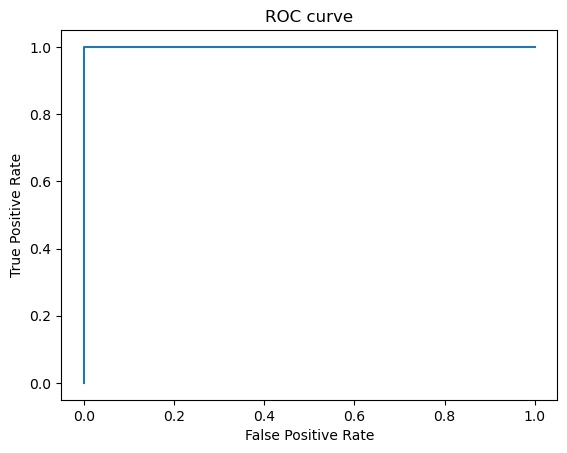

[2.0000000e+00 1.0000000e+00 1.0100319e-03]


In [15]:
print("ROC AUC Score train: ", roc_auc_score(y_train, pred_probabilities_train))
print("ROC AUC Score test: ", roc_auc_score(y_test, pred_probabilities_test))
# plot a auc curve

fpr, tpr, thresholds = roc_curve(y_test, pred_probabilities_test)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()
print(thresholds)

# Dumpster

In [16]:
# roc_auc_score(true_labels, pred_probabilities)
# # plot a auc curve
# from sklearn.metrics import roc_curve
# fpr, tpr, thresholds = roc_curve(true_labels, pred_probabilities)
# plt.plot(fpr, tpr)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC curve')
# plt.show()
# print(thresholds)

In [17]:
## Get Layers manually approach

# features = torch.nn.ModuleList(vgg16_model.features.children())
# model_features = torch.nn.Sequential(*features)
# some_more_layers = torch.nn.Sequential(torch.nn.Flatten(start_dim=1))

# model_1 = torch.nn.Sequential(model_features,
#                       some_more_layers)
# model_1.eval()
# summary(model_1, (3, 256, 256))
# print(model_1(images_0).size())

In [18]:
# Flatten not as part of model approach

# billo = vgg16_model.features
# billo.eval()
# summary(billo, (3, 256, 256))
# print("input size", images_0[0].size())
# rep = billo(images_0[0])
# print("output size", rep.size())
# torch.nn.Flatten(start_dim=0)(rep).size()
# # apply model on images_0

In [19]:
# billo = vgg16_model.features
# billo.eval()
# rep = billo(images_0)
# print("input size", rep.size())
# torch.nn.Flatten(start_dim=1)(rep).size()

# Sensitivity Analysis

In [20]:
w_layer = torch.nn.Linear(in_features=X_representation_train.size()[1],
                          out_features=1,
                          bias=False)

# add weight layer to model to get mean difference model
model_diff = model.append(w_layer).to(device)

# with torch.no_grad():
model_diff[-1].weight = torch.nn.Parameter(w)

print((model_diff[-1].weight == w).all())
print(model_diff[-1].weight)

tensor(True)
Parameter containing:
tensor([-0.0012, -0.0005,  0.0003,  ...,  0.0000,  0.0000,  0.0000],
       requires_grad=True)


-1
-1
tensor([-5.6218], grad_fn=<MvBackward0>)
tensor([[[[0.6863, 0.7255, 0.7294,  ..., 0.3451, 0.3647, 0.3843],
          [0.7686, 0.8118, 0.7333,  ..., 0.3294, 0.3451, 0.3608],
          [0.7294, 0.7804, 0.6706,  ..., 0.3451, 0.3569, 0.3686],
          ...,
          [0.7137, 0.7137, 0.7176,  ..., 0.6745, 0.6667, 0.6627],
          [0.7098, 0.7137, 0.7176,  ..., 0.6784, 0.6784, 0.6784],
          [0.6980, 0.7020, 0.7059,  ..., 0.6863, 0.6902, 0.6980]],

         [[0.6353, 0.6745, 0.6784,  ..., 0.3451, 0.3647, 0.3843],
          [0.7176, 0.7608, 0.6824,  ..., 0.3294, 0.3451, 0.3608],
          [0.6784, 0.7294, 0.6196,  ..., 0.3451, 0.3569, 0.3686],
          ...,
          [0.7216, 0.7216, 0.7255,  ..., 0.7216, 0.7137, 0.7098],
          [0.7176, 0.7216, 0.7255,  ..., 0.7255, 0.7255, 0.7255],
          [0.7059, 0.7098, 0.7137,  ..., 0.7333, 0.7373, 0.7451]],

         [[0.6706, 0.7098, 0.7137,  ..., 0.4392, 0.4588, 0.4784],
          [0.7529, 0.7961, 0.7176,  ..., 0.4235, 0.4392, 0.45

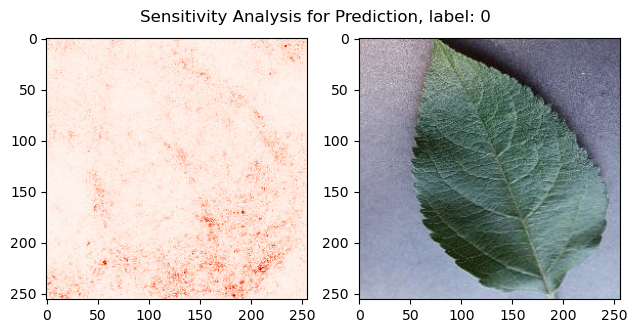

In [22]:
img_id = 8
img = images[img_id].to(device)
print(img.get_device())
input_data = torch.autograd.Variable(img.unsqueeze(0), requires_grad=True)
print(input_data.get_device())
output = model_diff(input_data)
print(output)
output.backward()  # torch.ones_like(output)
gradients = input_data.grad
print(input_data)
sensitivity = gradients.norm(dim=1).to("cpu")

# plot to images
fig, axs = plt.subplots(1,2)

axs[0].imshow(sensitivity.squeeze(0), cmap="Reds")
axs[1].imshow(torch.permute(images[img_id], (1, 2, 0)))
fig.suptitle(f"Sensitivity Analysis for Prediction, label: {labels[img_id]}", y=0.8)
plt.tight_layout()
plt.show()

In [23]:
sensitivity

tensor([[[0.0281, 0.0349, 0.0942,  ..., 0.0468, 0.0266, 0.0518],
         [0.0281, 0.0516, 0.1332,  ..., 0.1044, 0.0979, 0.0780],
         [0.0190, 0.0575, 0.1348,  ..., 0.1501, 0.0995, 0.1013],
         ...,
         [0.0289, 0.0611, 0.0308,  ..., 0.0356, 0.0266, 0.0166],
         [0.0433, 0.0671, 0.0285,  ..., 0.0327, 0.0333, 0.0097],
         [0.0295, 0.0324, 0.0354,  ..., 0.0196, 0.0126, 0.0058]]])

# More robust explanations

In [24]:
class BiasedLayer(torch.nn.Module):
    def __init__(self, ConvLayer):
        super().__init__()
        self.biased_conv = copy.deepcopy(ConvLayer)
        self.og_conv = ConvLayer

        self.biased_conv.weight = torch.nn.Parameter(self.og_conv.weight + (0.25 * torch.maximum(torch.zeros_like(self.og_conv.weight), self.og_conv.weight)))
        self.biased_conv.bias = torch.nn.Parameter(self.og_conv.bias + (0.25 * torch.maximum(torch.zeros_like(self.og_conv.bias), self.og_conv.bias)))


    def forward(self, X):
        biased_out = self.biased_conv.forward(X)
        og_out = self.og_conv.forward(X)

        return biased_out * (og_out / biased_out).detach()

In [25]:
# test biased layer with a tensor

# create Conv2d layer
test_conv = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0, bias=True)
test_conv.weight = torch.nn.Parameter(torch.tensor([[[[1., 1., 1.],
                                                        [1., 1., 1.],
                                                        [1., 1., 1.]]]]))
test_conv.bias = torch.nn.Parameter(torch.tensor([1.]))

# Convert it to BiasedLayer instance
test = BiasedLayer(test_conv)
# Check if the weights and biases are freezed for parts of the model
print(test.biased_conv.bias.requires_grad)
print(test.og_conv.bias.requires_grad)

# Create Artificial Input
input_data = torch.tensor([[[[1., 1., 1.],
                            [1., 1., 1.],
                            [1., 1., 1.]]]], requires_grad=True)

# Run forward pass and retrieve sensitivity
output = test(input_data)
print(output)
output.backward()  # Backward pass with a gradient of ones torch.ones_like(output)
gradients = input_data.grad
sensitivity = gradients.norm(dim=1)
sensitivity

True
True
tensor([[[[10.]]]], grad_fn=<MulBackward0>)


tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]])

In [26]:
output = test_conv(input_data)
print(output)
output.backward()  # Backward pass with a gradient of ones torch.ones_like(output)
gradients = input_data.grad
sensitivity = gradients.norm(dim=1)
sensitivity

tensor([[[[10.]]]], grad_fn=<ConvolutionBackward0>)


tensor([[[2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.]]])

# Customize all layers from VGG

In [27]:
end_model = nn.Sequential()
i = 0
for layer in model_diff.children():
    if isinstance(layer, torch.nn.Conv2d) & (i != 0): # last linear layer is not considered by default
        biased_layer = BiasedLayer(layer)
        end_model.append(biased_layer)
    else:
        end_model.append(layer)
    i = 1

end_model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): BiasedLayer(
    (biased_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (og_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): BiasedLayer(
    (biased_conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (og_conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (6): ReLU(inplace=True)
  (7): BiasedLayer(
    (biased_conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (og_conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): BiasedLayer(
    (biased_conv): Conv2d(128, 256, kernel_size=(3,

In [28]:
img_id = 0
img = images[img_id].to(device)
input_data = torch.autograd.Variable(img.unsqueeze(0), requires_grad=True)
output = end_model(input_data)
print("Old Output: ", output)
output.backward()  # Backward pass with a gradient of ones torch.ones_like(output)
gradients = input_data.grad.norm(dim=1)
print(sensitivity)
print(sensitivity.sum())
print("New Output: ", model_diff(input_data))

Old Output:  tensor([-15.3213], grad_fn=<MvBackward0>)
tensor([[[2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.]]])
tensor(18.)
New Output:  tensor([-15.3213], grad_fn=<MvBackward0>)


Try also to normalize data s.t. the mean is 0 and std is 1 for each channel across the train set

In [29]:
X_train_mean = X_train.mean(dim=0)
X_train_std = X_train.std(dim=0)
#input_data = torch.autograd.Variable(img.unsqueeze(0), requires_grad=True).to(device)
img_standardized = (img - X_train_mean) / X_train_std
print(img_standardized.size())
input_data = torch.autograd.Variable(img_standardized.unsqueeze(0), requires_grad=True).to(device)
print(input_data.size())
output = end_model(input_data)
print(output)
output.backward()

torch.Size([3, 256, 256])
torch.Size([1, 3, 256, 256])
tensor([-2.0377], grad_fn=<MvBackward0>)


In [30]:
def plot_sensitivity_img_ids(img_ids):
    fig, axs = plt.subplots(len(img_ids),4, figsize=(20, 15))

    for i, img_id in enumerate(img_ids):
        img = X[img_id].to(device)
        input_data = torch.autograd.Variable(img.unsqueeze(0), requires_grad=True)
        output = end_model(input_data)
        output.backward()
        sensitivity_end = input_data.grad.norm(dim=1).to("cpu")

        img_standardized = (img - X_train_mean) / X_train_std
        input_data = torch.autograd.Variable(img_standardized.unsqueeze(0), requires_grad=True).to(device)
        output = end_model(input_data)
        output.backward()
        sensitivity_end_norm = input_data.grad.norm(dim=1).to("cpu")


        output = model_diff(input_data)
        output.backward()
        sensitivity_diff = input_data.grad.norm(dim=1).to("cpu")



        axs[i, 0].imshow(torch.permute(img, (1, 2, 0)))
        axs[i, 1].imshow(sensitivity_end.squeeze(0), cmap="Reds")
        axs[i, 2].imshow(sensitivity_end_norm.squeeze(0), cmap="Reds")
        axs[i, 3].imshow(sensitivity_diff.squeeze(0), cmap="Reds")


        if i == 0:
            axs[i, 0].set_title(f"Original Image")
            axs[i, 1].set_title(f"'Asymmetric' Gradient")
            axs[i, 2].set_title(f"'Asymmetric' Gradient (Standardized)")
            axs[i, 3].set_title(f"'Normal' Gradient")

        fig.suptitle(f"Gradient Sensitivity Analysis for Prediction")
    # set ticks off for all subplots
    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])

    fig.subplots_adjust(hspace=0.8)
    plt.tight_layout()
    plt.show()

In [35]:
def plot_sensitivity(img):
    fig, axs = plt.subplots(1,4, figsize=(20, 15))


    input_data = torch.autograd.Variable(img.unsqueeze(0), requires_grad=True).to(device)
    output = end_model(input_data)
    output.backward()
    sensitivity_end = input_data.grad.norm(dim=1)

    output = model_diff(input_data)
    output.backward()
    sensitivity_diff = input_data.grad.norm(dim=1)


    input_data = (img - X_train_mean) / X_train_std
    input_data = torch.autograd.Variable(input_data.unsqueeze(0), requires_grad=True).to(device)
    output = end_model(input_data)
    output.backward()
    sensitivity_end_norm = input_data.grad.norm(dim=1)

    print((sensitivity_end_norm == sensitivity_end).all())
    axs[0].imshow(torch.permute(img.to("cpu"), (1, 2, 0)))
    axs[1].imshow(sensitivity_end.squeeze(0), cmap="Reds")
    axs[2].imshow(sensitivity_end_norm.squeeze(0), cmap="Reds")
    axs[3].imshow(sensitivity_diff.squeeze(0), cmap="Reds")


    axs[0].set_title(f"Original Image")
    axs[1].set_title(f"'Asymmetric' Gradient")
    axs[2].set_title(f"'Asymmetric' Gradient (Standardized)")
    axs[3].set_title(f"'Normal' Gradient")

    fig.suptitle(f"Gradient Sensitivity Analysis for Prediction", y=0.8)
    # set ticks off for all subplots
    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])

    fig.subplots_adjust(hspace=0.7)
    plt.tight_layout()
    plt.show()

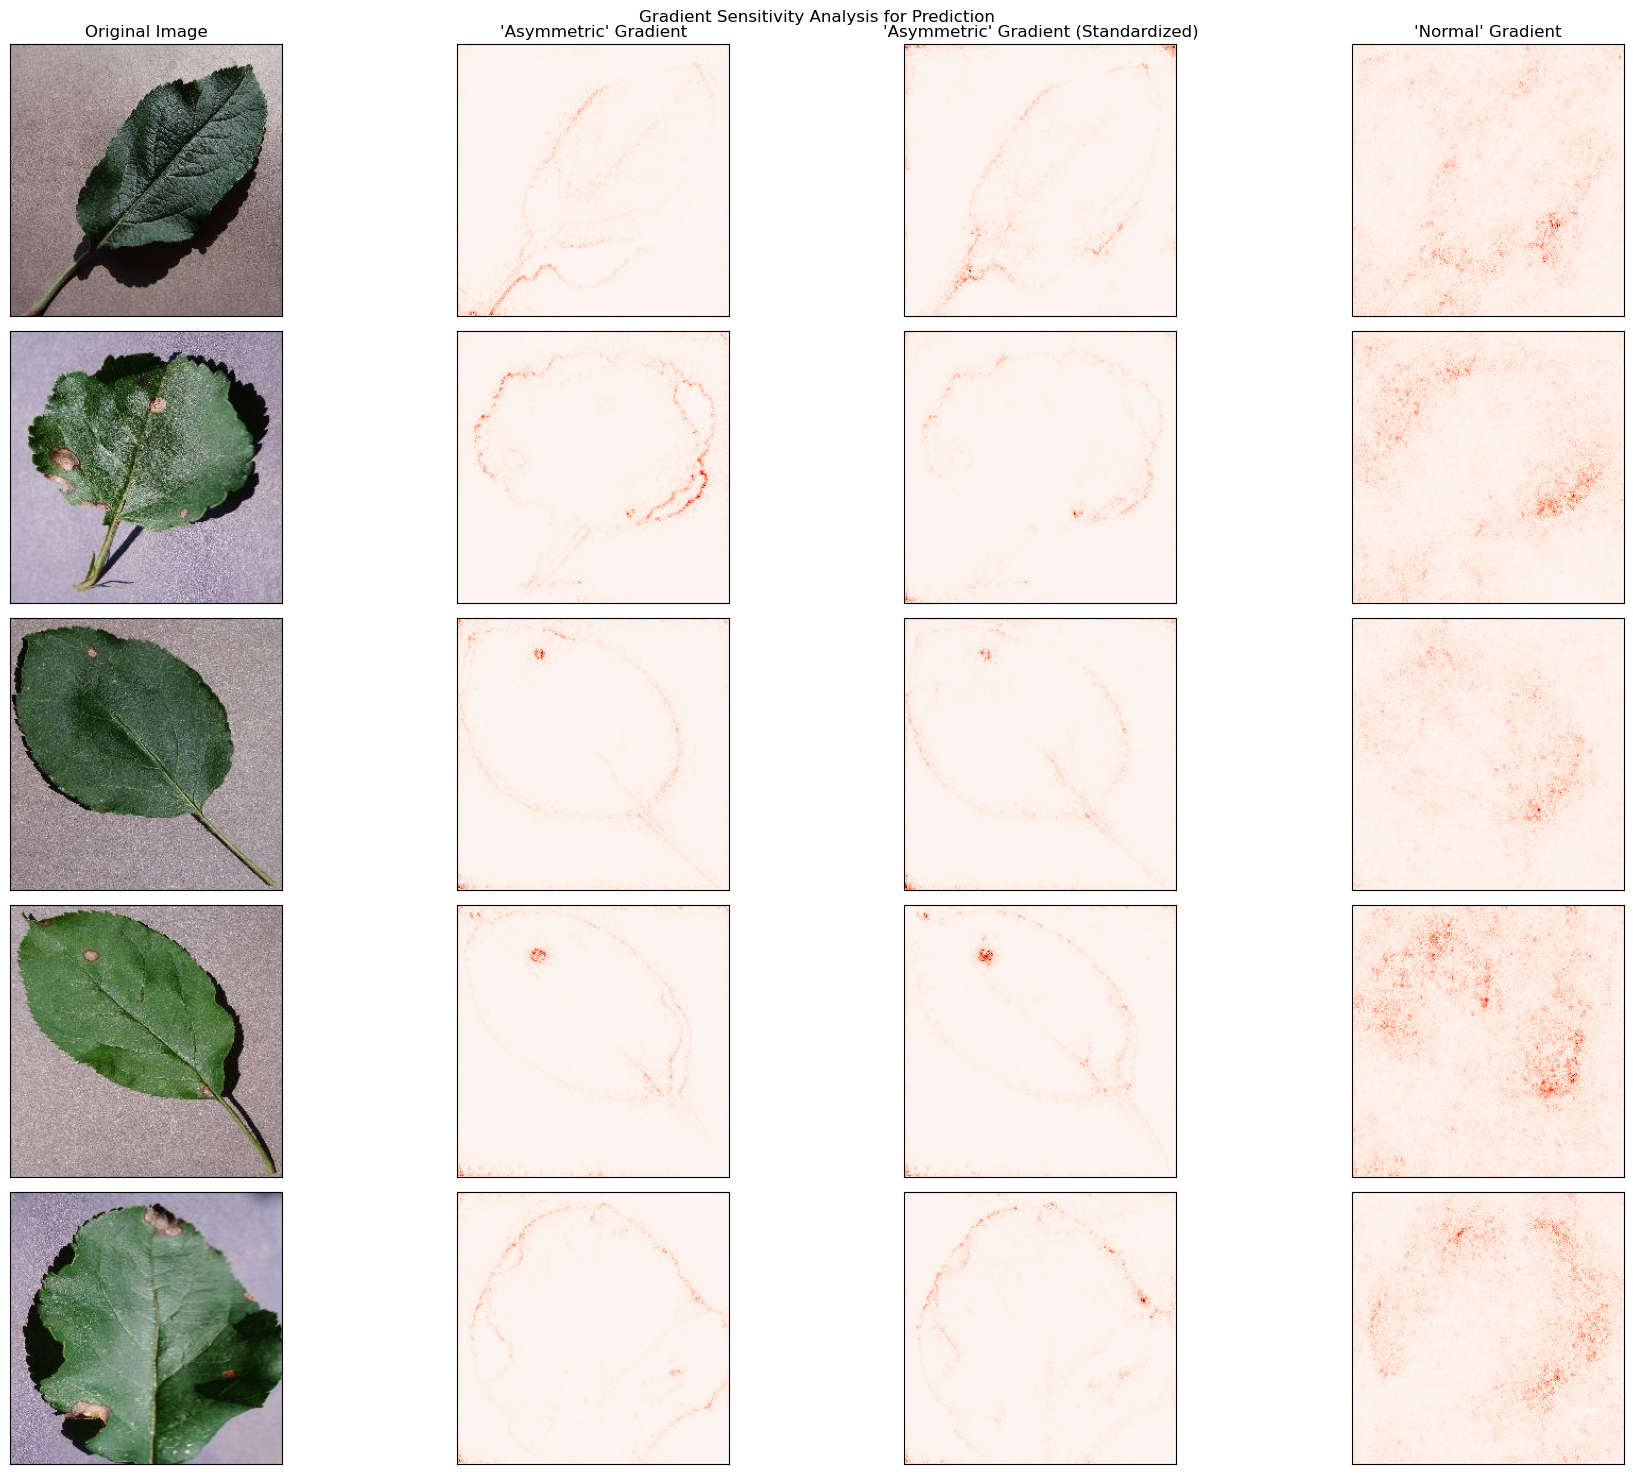

In [32]:
plot_sensitivity_img_ids([0, 11, 14, 16, 17]) # images[0] ist gut # [0,14]

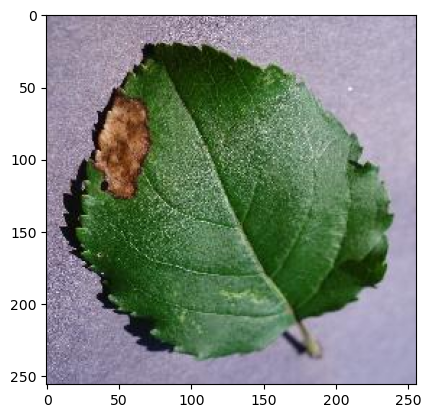

In [36]:
import cv2
import numpy as np

example_path = r".\data\Apple___Black_rot\image (50).jpg"

# use imshow to open image
img = cv2.imread(example_path)
img = img[...,::-1] / 255 # convert from BGR to RGB
plt.imshow(img)
img = torch.FloatTensor(img.copy()).permute(2, 0, 1)


tensor(False)


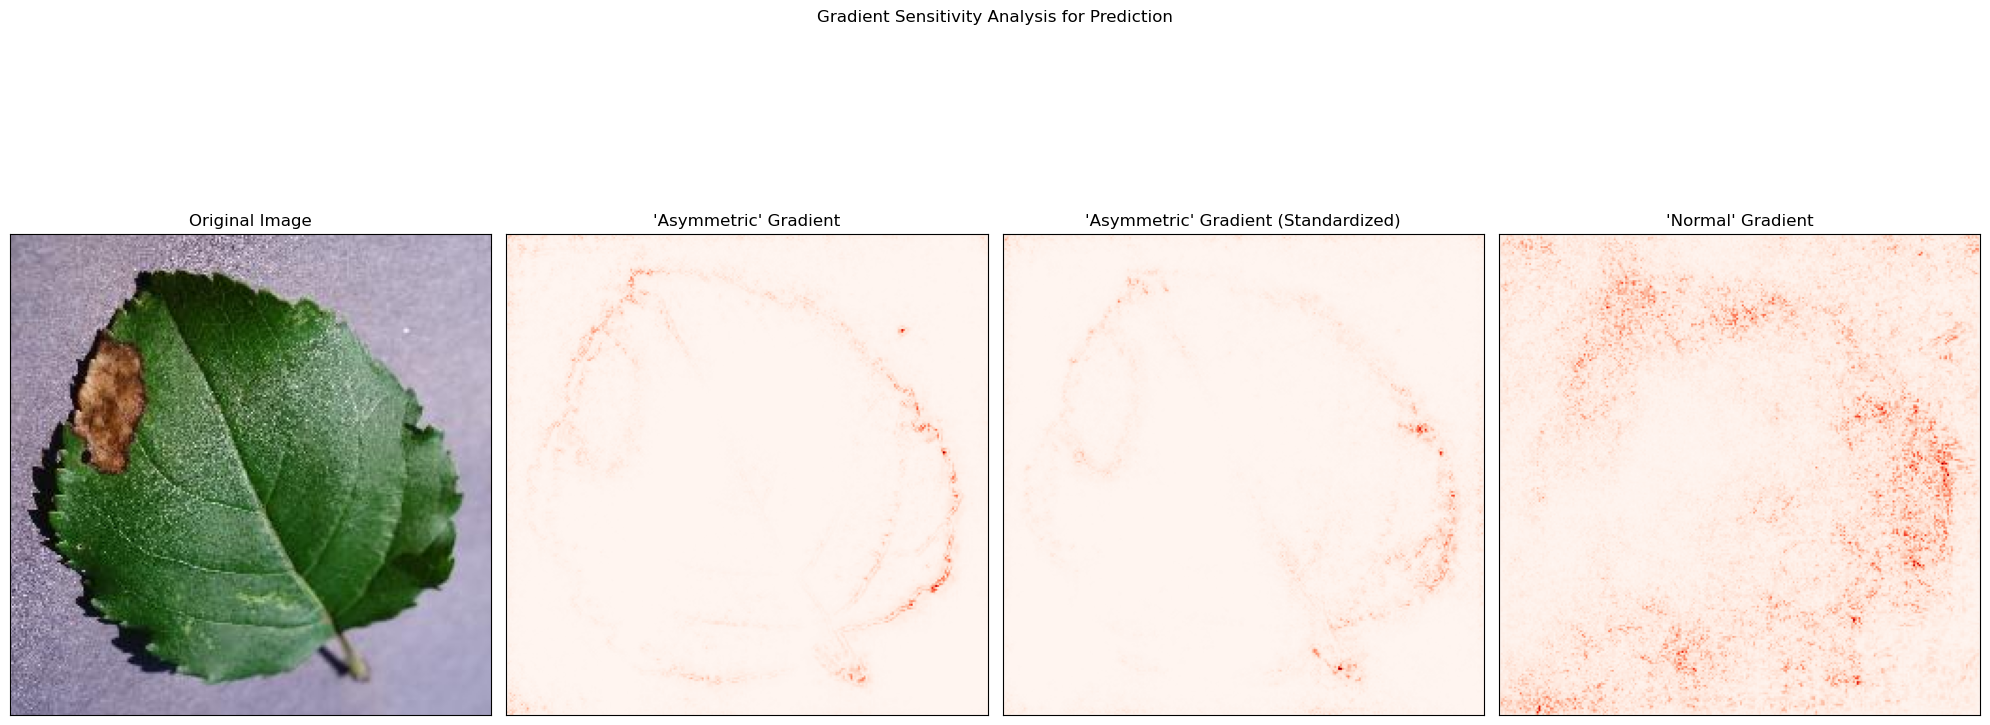

In [37]:
plot_sensitivity(img)

# Discussion
Possible sources of mismatch:


## Insufficiently good pretrained neural network
- the pretext training is just not trained good enough to derive generalizable features; maybe not even for the pretext task itself
### Possible solutions:
- check model performance of pretrained model on upstream task
- try to fine-tune model on our task at hand
- check if there exist other downstream task are suitable to this approach (derive evidence that the approach might be valid)

## Improper method for extracting relevant features
- each layer of the pretext task probabely captures different aspects/features of the image
- taking the last layer may be an inacurate choice for the downstream task at hand, i.e. detecting the disease
- we can see that the contours are captured in our sensitivity analysis, which may indicate that the extracted features are related to capturing contours (or darker lines, since shadows which can be mistaken for dark areas on the leaf are also sometimes detected)
- also, the data set might be too different from our dataset (i.e. focussing on cars, animals, etc. instead of leaves)
### Possible solutions:
- Try cutting of more layers to extract features
- Try to fine-tune on dataset at hand

## Problems with data quality
- resoultion is quite low --> model can't capture detailed structures/features are too vague
- shadows might disturbe features/introduce unwanted noise hardening the detection of structures related to the disease

### Possible solutions:
- increase resolution of images with designated machine learning models
- try to remove shadows either manually or with other machine learning models
- manually subsample images with less shadows included
- try to get images with higher resolution and/or without shadows in the picture to reduce noise

## Flawed understanding by the human of the plant disease
- disease might effect subtle areas of the plant which might be either hard to detect for a human or even unkown to humans due to its hard decetability
### Possible solutions:
- get in touch with people with domain knowledge
- double-check if there might be subtle structures changing due to the disease which might be unknown so far to the domain-experts